## Fetching NVIDIA stock price data from Yagoo Finance

In [27]:
import yfinance as yf
import pandas as pd

nvda_yahoo_stock = yf.download('NVDA', start='2020-01-01', end='2024-11-19')

# Clean-up
nvda_yahoo_stock.columns = [col[0] if isinstance(col, tuple) else col for col in nvda_yahoo_stock.columns]
nvda_yahoo_stock.reset_index(inplace=True)
nvda_yahoo_stock.rename(columns={"Date": "date"}, inplace=True)
nvda_yahoo_stock['date'] = nvda_yahoo_stock['date'].dt.date

print(nvda_yahoo_stock.head())
print(nvda_yahoo_stock.columns)

# save to csv file
# nvda_yahoo_stock.to_csv('nvda_stock_data.csv', index=False)

[*********************100%***********************]  1 of 1 completed

         date  Adj Close    Close     High      Low     Open     Volume
0  2020-01-02   5.972710  5.99775  5.99775  5.91800  5.96875  237536000
1  2020-01-03   5.877111  5.90175  5.94575  5.85250  5.87750  205384000
2  2020-01-06   5.901757  5.92650  5.93175  5.78175  5.80800  262636000
3  2020-01-07   5.973209  5.99825  6.04425  5.90975  5.95500  314856000
4  2020-01-08   5.984411  6.00950  6.05100  5.95375  5.99400  277108000
Index(['date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [29]:
# checking missing values
print("Yahoo Missing Values:\n", nvda_yahoo_stock.isnull().sum())

Yahoo Missing Values:
 date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


No missing values from nvda_yahoo is checked.

## Fetching news from google news (general)

In [31]:
from GoogleNews import GoogleNews
import pandas as pd

googlenews = GoogleNews(lang='en', period='5y')
# googlenews.set_time_range('01/01/2020','11/19/2024')
googlenews.search('NVIDIA')
googlenews.get_news('NVIDIA')
news_results = googlenews.results(sort=True)

news_data = []
for news in news_results:
    news_data.append({
        'title': news['title'],
        'date': news['date'],
        'media': news['media'],
        'url': news['link'],
        'desc': news['desc']
    })

google_news_df = pd.DataFrame(news_data)

# Save to CSV
# google_news_df.to_csv('nvidia_google_news.csv', index=False)


# Data Information
print(google_news_df.head())
print(f"Total articles saved: {len(google_news_df)}")

'<' not supported between instances of 'datetime.datetime' and 'float'
                                               title           date  \
0  Nvidia's new GPU series led an avalanche of en...  1 minutes ago   
1  Nvidia, Micron, Tesla, Aurora Innovation, Carv...  7 minutes ago   
2  Live Updates CES 2025: Nvidia follow-ups and L...     1 hour ago   
3  Stock market today: Nasdaq leads stock decline...     1 hour ago   
4  Nvidia Slides After Unveiling Leaves Investors...     1 hour ago   

           media                                                url  \
0  Yahoo Finance  https://finance.yahoo.com/news/nvidia-founder-...   
1       Barron's  https://www.barrons.com/articles/stock-market-...   
2     TechCrunch  https://techcrunch.com/storyline/live-updates-...   
3  Yahoo Finance  https://finance.yahoo.com/news/live/stock-mark...   
4  Yahoo Finance  https://finance.yahoo.com/news/nvidia-ceo-unve...   

                                                desc  
0  In a packed Las V

## Fetching news from Benzinga API (Financial news - domain specific)

In [49]:
import os
import requests
import pandas as pd
from collections import Counter

API_KEY="ecf3d1671a2f49618d1bde23fc209bc2"
url = 'https://api.benzinga.com/api/v2/news'
headers = {"accept": "application/json"}
total_articles = 2000
page = 1
news_data = []

# Benzinga's api only allows pagesize up to 100, so I will iterate until I reach the target number of articles
while len(news_data) < total_articles:
    querystring = {
        "token": API_KEY,
        "dateFrom": "2020-01-01",
        "dateTo": "2024-11-19",
        "topics": "NVDA",
        "pageSize": 100,
        "page": page
    }
    
    response = requests.request("GET", url, headers=headers, params=querystring)
    
    if response.status_code == 200:
        data = response.json()
        
        if not data:
            print("No more articles returned by the API.")
            break
        
        for article in data:
            news_data.append({
                'id': article.get('id'),
                'title': article.get('title'),
                'body': article.get('body'),
                'channels': article.get('channels'),
                'url': article.get('url'),
                'publish_date': article.get('created'),
                'stocks': article.get('stocks'),
                'tags': article.get('tags')
            })
        
        print(f"Fetched {len(data)} articles from page {page}. Total articles fetched: {len(news_data)}.")
        page += 1  # Increment the page number
    else:
        print(f"Failed to fetch news from page {page}: {response.status_code}, {response.text}")
        break

benzinga_news_df = pd.DataFrame(news_data)

benzinga_news_df = pd.read_csv("benzinga_news.csv")
news_data = benzinga_news_df.to_dict('records')

# Save to CSV
# benzinga_news_df.to_csv('nvidia_benzinga_news.csv', index=False)

# Data Information
print(benzinga_news_df.head())
print(f"Total articles saved: {len(benzinga_news_df)}")

Failed to fetch news from page 1: 401, ["Access denied for user 0 \"anonymous\""]
news_data dict_keys(['date', 'news_content', 'url'])
         date                                       news_content  \
0  2024-11-20  Stock Market Today: Dow heads for fifth day of...   
1  2024-11-20  Stanley Black & Decker updates targets, plus N...   
2  2024-11-20  Stocks fall as Nvidia dips before earnings rep...   
3  2024-11-20  Stock Market News Today: Dow, Nasdaq Slip; Inv...   
4  2024-11-20  Nvidia On Deck. Will Report Spark Rally? (Live...   

                                                 url  
0  https://www.marketwatch.com/livecoverage/stock...  
1  https://www.cnbc.com/2024/11/20/stanley-black-...  
2  https://www.cnbc.com/2024/11/19/stock-market-t...  
3  https://www.wsj.com/livecoverage/nvidia-earnin...  
4  https://www.investors.com/news/technology/nvid...  
Total articles saved: 578


In [47]:
most_common_stocks = Counter([stock['name'] for article in news_data if article['stocks'] for stock in article['stocks']]).most_common(10)
print("Most common 10 stocks:", most_common_stocks)

KeyError: 'stocks'

In [51]:
print(benzinga_news_df.shape)
print(benzinga_news_df.columns)

(578, 3)
Index(['date', 'news_content', 'url'], dtype='object')


## Combine Google News and Benzinga News

In [53]:
from datetime import datetime, timedelta
import re

# Some date in google news is in relative dates like “2 minutes ago” or “1 hour ago”.
# Process Google News Dates into proper datetime objects.
def convert_google_date(date_str):
    """
    Convert Google News relative date strings into datetime objects.
    """
    now = datetime.now()
    
    # Check if input is already a datetime object
    if isinstance(date_str, (datetime, pd.Timestamp)):
        return date_str
    
    # Handle relative date strings
    if isinstance(date_str, str):
        if "minute" in date_str:
            minutes = int(re.search(r'\d+', date_str).group())
            return now - timedelta(minutes=minutes)
        elif "hour" in date_str:
            hours = int(re.search(r'\d+', date_str).group())
            return now - timedelta(hours=hours)
        elif "day" in date_str:
            days = int(re.search(r'\d+', date_str).group())
            return now - timedelta(days=days)
        elif "week" in date_str:
            weeks = int(re.search(r'\d+', date_str).group())
            return now - timedelta(weeks=weeks)
        else:
            # Handle standard date formats # e.g., "Nov 13, 2023"
            try:
                # If the date string doesn't include a year, assume the current year # e.g., "Mar 18"
                if re.match(r'^[A-Za-z]{3} \d{1,2}$', date_str):
                    return datetime.strptime(f"{date_str} {now.year}", '%b %d %Y')
                return datetime.strptime(date_str, '%b %d, %Y')
            except ValueError:
                return None
    return None  # If it's neither string nor datetime, return None

google_news_df['date'] = google_news_df['date'].apply(convert_google_date)
google_news_df['date'] = pd.to_datetime(google_news_df['date'])

# Combine Google News Title and Description
google_news_df['content'] = google_news_df['title'].fillna('') + ". " + google_news_df['desc'].fillna('') # Avoid getting NaN if there's any NaN value in either column
print(len(google_news_df))
print("google news title nan", google_news_df["title"].isnull().sum())
print("google news desc nan", google_news_df["desc"].isnull().sum())

# Process Benzinga Dates
benzinga_news_df['publish_date'] = pd.to_datetime(benzinga_news_df['publish_date'], errors='coerce')
benzinga_news_df['publish_date'] = benzinga_news_df['publish_date'].dt.tz_localize(None)  # Remove timezone information

# Select relevant columns
google_news_df = google_news_df[['date', 'content', 'url']]
benzinga_news_df = benzinga_news_df[['publish_date', 'title', 'url']]

# Rename columns for consistency
google_news_df.rename(columns={'date': 'date', 'content': 'news_content', 'url': 'url'}, inplace=True)
benzinga_news_df.rename(columns={'publish_date': 'date', 'title': 'news_content', 'url': 'url'}, inplace=True)

benzinga_news_df['date'] = pd.to_datetime(benzinga_news_df['date']).dt.date

print("google_news_df", google_news_df)
print("benzinga_news_df", benzinga_news_df)
print("google news content nan", google_news_df["news_content"].isnull().sum())
print("benzinga news content nan", benzinga_news_df["news_content"].isnull().sum())

110
google news title nan 0
google news desc nan 100


KeyError: 'publish_date'

In [19]:
# google_news_df.to_csv('cleaned_up_google_news.csv', index=False)


In [65]:
# Combine datasets
combined_news = pd.concat([google_news_df, benzinga_news_df], ignore_index=True)

combined_news['date'] = pd.to_datetime(combined_news['date']).dt.date

print(combined_news)

# Save to CSV
# combined_news.to_csv("nvidia_combined_news.csv", index=False)
# combined_news = pd.read_csv("nvidia_combined_news.csv")

                                                 title        date  \
0    Nvidia's new GPU series led an avalanche of en...  2025-01-07   
1    Nvidia, Micron, Tesla, Aurora Innovation, Carv...  2025-01-07   
2    Live Updates CES 2025: Nvidia follow-ups and L...  2025-01-07   
3    Stock market today: Nasdaq leads stock decline...  2025-01-07   
4    Nvidia Slides After Unveiling Leaves Investors...  2025-01-07   
..                                                 ...         ...   
683                                                NaN  2024-11-19   
684                                                NaN  2024-11-19   
685                                                NaN  2024-11-19   
686                                                NaN  2024-11-19   
687                                                NaN  2024-11-19   

             media                                                url  \
0    Yahoo Finance  https://finance.yahoo.com/news/nvidia-founder-...   
1         Bar

In [69]:
import re
from nltk.corpus import stopwords

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text
combined_news['cleaned_text'] = combined_news['news_content'].apply(clean_text)
# google_news_df['cleaned_text'] = google_news_df['news_content'].apply(clean_text)
# benzinga_news_df['cleaned_text'] = benzinga_news_df['news_content'].apply(clean_text)

# Display changed rows
combined_news['text_changed'] = combined_news['news_content'] != combined_news['cleaned_text']
changed_rows = combined_news[combined_news['text_changed']]
print(changed_rows[['news_content', 'cleaned_text']])

                                          news_content  \
0    Stock Market Today: Dow heads for fifth day of...   
1    Stanley Black & Decker updates targets, plus N...   
2    Stocks fall as Nvidia dips before earnings rep...   
3    Stock Market News Today: Dow, Nasdaq Slip; Inv...   
4    Nvidia On Deck. Will Report Spark Rally? (Live...   
..                                                 ...   
573  Not World War III But New Russian Nuclear Doct...   
574  Bitcoin, Dogecoin Gain, Ethereum Drops As Blac...   
575  Dan Ives Expects 'Drop The Mic Performance' To...   
576  Nvidia, Microstrategy, Apollo Global Managemen...   
577  Dogecoin, Bitcoin Left In The Dust By AI Meme ...   

                                          cleaned_text  
0    Stock Market Today Dow heads fifth day losses ...  
1    Stanley Black Decker updates targets plus Nvid...  
2    Stocks fall Nvidia dips earnings report Live u...  
3    Stock Market News Today Dow Nasdaq Slip Invest...  
4    Nvidia On Dec

## Perform Sentiment Analysis Using Three Different Options:

1. TextBlob
2. VADER (Valence Aware Dictionary and Sentiment Reasoner)
3. BERT


### 1. Textblob

In [71]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

combined_news['sentiment_polarity'] = combined_news['cleaned_text'].apply(get_sentiment)
# google_news_df['sentiment_polarity'] = google_news_df['cleaned_text'].apply(get_sentiment)
# benzinga_news_df['sentiment_polarity'] = benzinga_news_df['cleaned_text'].apply(get_sentiment)

def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    else:
        return 'Negative'

combined_news['textblob_sentiment'] = combined_news['sentiment_polarity'].apply(classify_sentiment)
# google_news_df['textblob_sentiment'] = google_news_df['sentiment_polarity'].apply(classify_sentiment)
# benzinga_news_df['textblob_sentiment'] = benzinga_news_df['sentiment_polarity'].apply(classify_sentiment)

In [73]:
# non clean

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

combined_news['nonclean_textblob_sentiment'] = combined_news['news_content'].apply(get_sentiment)
# google_news_df['nonclean_textblob_sentiment'] = google_news_df['news_content'].apply(get_sentiment)
# benzinga_news_df['nonclean_textblob_sentiment'] = benzinga_news_df['news_content'].apply(get_sentiment)

def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    else:
        return 'Negative'

combined_news['nonclean_textblob_sentiment'] = combined_news['nonclean_textblob_sentiment'].apply(classify_sentiment)
# google_news_df['nonclean_textblob_sentiment'] = google_news_df['nonclean_textblob_sentiment'].apply(classify_sentiment)
# benzinga_news_df['nonclean_textblob_sentiment'] = benzinga_news_df['nonclean_textblob_sentiment'].apply(classify_sentiment)

### 2. VADER

In [23]:
!pip install vaderSentiment

In [79]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['compound']  # Returns a value between -1 and 1

combined_news['sentiment_score'] = combined_news['cleaned_text'].apply(get_vader_sentiment)
# google_news_df['sentiment_score'] = google_news_df['cleaned_text'].apply(get_vader_sentiment)
# benzinga_news_df['sentiment_score'] = benzinga_news_df['cleaned_text'].apply(get_vader_sentiment)

def classify_vader_sentiment(score):
    # VADER’s documentation recommends a small margin around 0 (-0.05 to 0.05) to classify neutral text.
    if score > 0:
        return 'Positive'
    else:
        return 'Negative'

combined_news['vader_sentiment'] = combined_news['sentiment_score'].apply(classify_vader_sentiment)
# google_news_df['vader_sentiment'] = google_news_df['sentiment_score'].apply(classify_sentiment)
# benzinga_news_df['vader_sentiment'] = benzinga_news_df['sentiment_score'].apply(classify_sentiment)

In [81]:
#nonclean
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['compound']  # Returns a value between -1 and 1

combined_news['sentiment_score'] = combined_news['news_content'].apply(get_vader_sentiment)
# google_news_df['sentiment_score'] = google_news_df['cleaned_text'].apply(get_vader_sentiment)
# benzinga_news_df['sentiment_score'] = benzinga_news_df['cleaned_text'].apply(get_vader_sentiment)

def classify_vader_sentiment(score):
    # VADER’s documentation recommends a small margin around 0 (-0.05 to 0.05) to classify neutral text.
    if score > 0:
        return 'Positive'
    else:
        return 'Negative'

combined_news['nonclean_vader_sentiment'] = combined_news['sentiment_score'].apply(classify_vader_sentiment)
# google_news_df['vader_sentiment'] = google_news_df['sentiment_score'].apply(classify_sentiment)
# benzinga_news_df['vader_sentiment'] = benzinga_news_df['sentiment_score'].apply(classify_sentiment)

### 3. Transformer (distilBERT)

In [83]:
import tensorflow as tf
import keras
from transformers import pipeline

In [87]:
sentiment_pipeline = pipeline('sentiment-analysis', framework='tf') # model='distilbert-base-uncased-finetuned-sst-2-english' as default


def get_transformer_sentiment(text):
    result = sentiment_pipeline(text[:512])  # Truncate if text is too long
    return result[0]['label'], result[0]['score']

combined_news['transformer_sentiment'] = combined_news['cleaned_text'].apply(
    lambda x: get_transformer_sentiment(x)[0]
)
combined_news['transformer_confidence'] = combined_news['cleaned_text'].apply(
    lambda x: get_transformer_sentiment(x)[1]
)

# google_news_df['transformer_sentiment'] = google_news_df['cleaned_text'].apply(
#     lambda x: get_transformer_sentiment(x)[0]
# )
# google_news_df['transformer_confidence'] = google_news_df['cleaned_text'].apply(
#     lambda x: get_transformer_sentiment(x)[1]
# )

# benzinga_news_df['transformer_sentiment'] = benzinga_news_df['cleaned_text'].apply(
#     lambda x: get_transformer_sentiment(x)[0]
# )
# benzinga_news_df['transformer_confidence'] = benzinga_news_df['cleaned_text'].apply(
#     lambda x: get_transformer_sentiment(x)[1]
# )

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [89]:
#nonclean
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

def get_transformer_sentiment(text):
    result = sentiment_pipeline(text[:512])  # Truncate if text is too long
    return result[0]['label'], result[0]['score']

combined_news['nonclean_transformer_sentiment'] = combined_news['news_content'].apply(
    lambda x: get_transformer_sentiment(x)[0]
)
combined_news['nonclean_transformer_confidence'] = combined_news['news_content'].apply(
    lambda x: get_transformer_sentiment(x)[1]
)

Device set to use mps:0


In [91]:
print(combined_news['textblob_sentiment'].value_counts())
print(combined_news['vader_sentiment'].value_counts())
print(combined_news['transformer_sentiment'].value_counts())
# print(benzinga_news_df['transformer_sentiment'].value_counts())


print(combined_news['nonclean_textblob_sentiment'].value_counts())
print(combined_news['nonclean_vader_sentiment'].value_counts())
print(combined_news['nonclean_transformer_sentiment'].value_counts())

textblob_sentiment
Negative    370
Positive    208
Name: count, dtype: int64
vader_sentiment
Negative    345
Positive    233
Name: count, dtype: int64
transformer_sentiment
NEGATIVE    363
POSITIVE    215
Name: count, dtype: int64
nonclean_textblob_sentiment
Negative    370
Positive    208
Name: count, dtype: int64
nonclean_vader_sentiment
Negative    345
Positive    233
Name: count, dtype: int64
nonclean_transformer_sentiment
NEGATIVE    344
POSITIVE    234
Name: count, dtype: int64


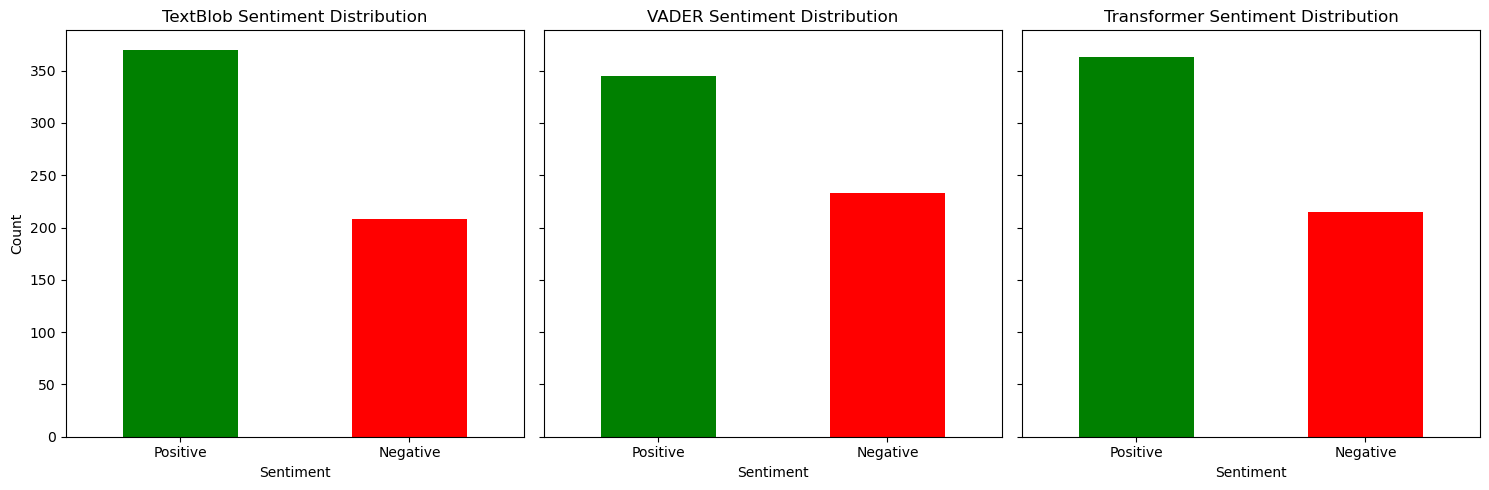

In [97]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# TextBlob sentiment distribution
combined_news['textblob_sentiment'].value_counts().plot(
    kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('TextBlob Sentiment Distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Positive', 'Negative'], rotation=0)

# VADER sentiment distribution
combined_news['vader_sentiment'].value_counts().plot(
    kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('VADER Sentiment Distribution')
axes[1].set_xlabel('Sentiment')
axes[1].set_xticklabels(['Positive', 'Negative'], rotation=0)

# Transformer sentiment distribution
combined_news['transformer_sentiment'].value_counts().plot(
    kind='bar', ax=axes[2], color=['green', 'red'])
axes[2].set_title('Transformer Sentiment Distribution')
axes[2].set_xlabel('Sentiment')
axes[2].set_xticklabels(['Positive', 'Negative'], rotation=0)

plt.tight_layout()
plt.show()

In [99]:
print(combined_news)

           date                                       news_content  \
0    2024-11-20  Stock Market Today: Dow heads for fifth day of...   
1    2024-11-20  Stanley Black & Decker updates targets, plus N...   
2    2024-11-20  Stocks fall as Nvidia dips before earnings rep...   
3    2024-11-20  Stock Market News Today: Dow, Nasdaq Slip; Inv...   
4    2024-11-20  Nvidia On Deck. Will Report Spark Rally? (Live...   
..          ...                                                ...   
573  2024-11-19  Not World War III But New Russian Nuclear Doct...   
574  2024-11-19  Bitcoin, Dogecoin Gain, Ethereum Drops As Blac...   
575  2024-11-19  Dan Ives Expects 'Drop The Mic Performance' To...   
576  2024-11-19  Nvidia, Microstrategy, Apollo Global Managemen...   
577  2024-11-19  Dogecoin, Bitcoin Left In The Dust By AI Meme ...   

                                                   url  \
0    https://www.marketwatch.com/livecoverage/stock...   
1    https://www.cnbc.com/2024/11/20/stanle

In [101]:
# combined_news.to_csv("combined_news_with_two_sentiments.csv", index=False)
# benzinga_news_df.to_csv("benzinga_news_with_sentiment.csv", index=False)